In [1]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 4.9 MB/s eta 0:00:00


In [2]:
!pip install transformers
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.8 MB/s eta 0:00:0

In [3]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import InputExample, InputFeatures
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
#code to work with data in google collab
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"

Mounted at /content/drive
/content/drive/MyDrive


In [5]:
df = pd.read_csv("preprocessed_data.csv")

In [6]:
df = df[["reviewText", "LABEL_COLUMN"]]
df = df.rename(columns={"reviewText":"DATA_COLUMN"})
df.head()

,DATA_COLUMN,LABEL_COLUMN
0,Heerlijk eten en leuke sfeer. Veel keuze bij h...,positive
1,Met z'n vieren dit restaurant bezocht. We hadd...,positive
2,Wait to be seated! We moesten lang wachten.Ont...,negative
3,Wij zijn volgens ons afspraak om 18.00 uur daa...,negative
4,Heerlijk gegeten!,positive


In [7]:
from transformers import AutoTokenizer 

tokenizer_bertje = AutoTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
tokenizer_robbert = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

In [8]:
def process_data_bertje(row):

    text = row['DATA_COLUMN']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer_bertje(text, padding=True, truncation=True, max_length=128)

    label = 0
    if row['LABEL_COLUMN'] == 'positive':
        label += 1

    encodings['label'] = int(label)
    encodings['text'] = text

    return encodings

In [9]:
def process_data_robbert(row):

    text = row['DATA_COLUMN']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer_robbert(text, padding=True, truncation=True, max_length=128)

    label = 0
    if row['LABEL_COLUMN'] == 'positive':
        label += 1

    encodings['label'] = int(label)
    encodings['text'] = text

    return encodings

In [10]:
processed_data_bertje = []
df = df.sample(100000, random_state=123)

for i in range(len(df)):
    processed_data_bertje.append(process_data_bertje(df.iloc[i]))



In [11]:
processed_data_robbert = []
df = df.sample(100000, random_state=123)

for i in range(len(df)):
    processed_data_robbert.append(process_data_robbert(df.iloc[i]))

In [12]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

new_df_bertje = pd.DataFrame(processed_data_bertje)
#columns_titles = ["attention_mask","input_ids","token_type_ids", "label", "text"]
#new_df=new_df.reindex(columns=columns_titles)

train_df_bertje, valid_df_bertje = train_test_split(
    new_df_bertje,
    test_size=0.2,
    random_state=2022
)

In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

new_df_robbert = pd.DataFrame(processed_data_robbert)
#columns_titles = ["attention_mask","input_ids","token_type_ids", "label", "text"]
#new_df=new_df.reindex(columns=columns_titles)

train_df_robbert, valid_df_robbert = train_test_split(
    new_df_robbert,
    test_size=0.2,
    random_state=2022
)

In [14]:
import pyarrow as pa
import tensorflow as tf
from datasets import Dataset


train_hg_bertje = Dataset(pa.Table.from_pandas(train_df_bertje))
valid_hg_bertje = Dataset(pa.Table.from_pandas(valid_df_bertje))


train_hg_robbert = Dataset(pa.Table.from_pandas(train_df_robbert))
valid_hg_robbert = Dataset(pa.Table.from_pandas(valid_df_robbert))



In [15]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_bertje = AutoModelForSequenceClassification.from_pretrained('./bertje_100k/')
model_robbert = AutoModelForSequenceClassification.from_pretrained('./robbert_100k/')

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',           # output directory
    num_train_epochs=3,               # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=128,  # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',             # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

trainer_bertje = Trainer(
    model=model_bertje,
    args=training_args,
    train_dataset=train_hg_bertje,
    eval_dataset=valid_hg_bertje,
    tokenizer=tokenizer_bertje
)

trainer_robbert = Trainer(
    model=model_robbert,
    args=training_args,
    train_dataset=train_hg_robbert,
    eval_dataset=valid_hg_robbert,
    tokenizer=tokenizer_robbert
)

In [17]:
predictions_bertje = trainer_bertje.predict(valid_hg_bertje)
predictions_robbert = trainer_robbert.predict(valid_hg_robbert)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [18]:
import math

probabilities1 = pd.DataFrame(predictions_bertje[0])
#probabilities[0]
probabilities1["exp_1"] = probabilities1[0].apply(lambda x: math.exp(x))
probabilities1["exp_2"] = probabilities1[1].apply(lambda x: math.exp(x))
probabilities1["sum"] = probabilities1["exp_1"] + probabilities1["exp_2"]
probabilities1["final_1"] = probabilities1["exp_1"] / probabilities1["sum"]
probabilities1["final_2"] = probabilities1["exp_2"] / probabilities1["sum"]
probabilities1 = probabilities1[["final_1", "final_2"]]
probabilities1 = probabilities1.rename(columns = {"final_1":0,"final_2":1})

In [19]:
predicted_bertje = probabilities1.idxmax(axis=1)
predicted_bertje

0        1
1        1
2        0
3        1
4        1
        ..
19995    1
19996    1
19997    0
19998    1
19999    1
Length: 20000, dtype: int64

In [20]:
actual_bertje = predictions_bertje[1]

In [21]:
import math

probabilities2 = pd.DataFrame(predictions_robbert[0])
#probabilities[0]
probabilities2["exp_1"] = probabilities2[0].apply(lambda x: math.exp(x))
probabilities2["exp_2"] = probabilities2[1].apply(lambda x: math.exp(x))
probabilities2["sum"] = probabilities2["exp_1"] + probabilities2["exp_2"]
probabilities2["final_1"] = probabilities2["exp_1"] / probabilities2["sum"]
probabilities2["final_2"] = probabilities2["exp_2"] / probabilities2["sum"]
probabilities2 = probabilities2[["final_1", "final_2"]]
probabilities2 = probabilities2.rename(columns = {"final_1":0,"final_2":1})

In [22]:
predicted_robbert = probabilities2.idxmax(axis=1)

In [23]:
actual_robbert = predictions_robbert[1]

In [24]:
# confusion matrix: actual vs predicted counts
from sklearn.metrics import confusion_matrix
confmat_bertje =  confusion_matrix(actual_bertje,predicted_bertje)
confmat_bertje

array([[ 4386,   168],
       [  129, 15317]])

In [25]:
from sklearn.metrics import confusion_matrix
confmat_robbert = confusion_matrix(actual_robbert, predicted_robbert)
confmat_robbert

array([[ 4438,    43],
       [   19, 15500]])

In [26]:
# derive True Positive, False Positive, False Negative and True Negative from confusion matrix
TP_bertje = confmat_bertje[1,1]
FP_bertje = confmat_bertje[0,1]
FN_bertje = confmat_bertje[1,0]
TN_bertje = confmat_bertje[0,0]

In [27]:
TP_robbert = confmat_robbert[1,1]
FP_robbert = confmat_robbert[0,1]
FN_robbert = confmat_robbert[1,0]
TN_robbert = confmat_robbert[0,0]

In [28]:
accuracy_bertje = (TP_bertje+TN_bertje)/(TP_bertje+FP_bertje+FN_bertje+TN_bertje)
precision_bertje = TP_bertje/(TP_bertje+FP_bertje)
recall_bertje = TP_bertje/(TP_bertje+FN_bertje)
F1_bertje = 2*TP_bertje / (2*TP_bertje+FP_bertje+FN_bertje)
print("accuracy of bertje = ",accuracy_bertje)
print("precision of bertje = ", precision_bertje)
print("recall of bertje = ", recall_bertje)
print("F1-score of bertje = ", F1_bertje)

accuracy of bertje =  0.98515
precision of bertje =  0.9891507910881498
recall of bertje =  0.99164832319047
F1-score of bertje =  0.9903979826064466


In [29]:
accuracy_robbert = (TP_robbert + TN_robbert) / (TP_robbert + FP_robbert + FN_robbert + TN_robbert)
precision_robbert = TP_robbert / (TP_robbert+FP_robbert)
recall_robbert = TP_robbert / (TP_robbert+FN_robbert)
F1_robbert = 2*TP_robbert / (2*TP_robbert+FP_robbert+FN_robbert)

print("accuracy of robbert = ",accuracy_robbert)
print("precision of robbert = ", precision_robbert)
print("recall of robbert = ", recall_robbert)
print("F1-score of robbert = ", F1_robbert)

accuracy of robbert =  0.9969
precision of robbert =  0.9972334813099144
recall of robbert =  0.9987756943102004
F1-score of robbert =  0.998003992015968


In [30]:
import pandas as pd
actual_robbert = pd.DataFrame(actual_robbert)
predicted_robbert = pd.DataFrame(predicted_robbert)
text_robbert = pd.DataFrame(valid_hg_robbert["text"])
robbert = pd.concat([actual_robbert,predicted_robbert, text_robbert],axis=1)

actual_bertje = pd.DataFrame(actual_bertje)
predicted_bertje = pd.DataFrame(predicted_bertje)
text_bertje = pd.DataFrame(valid_hg_bertje["text"])
bertje = pd.concat([actual_bertje,predicted_bertje, text_bertje], axis=1)



In [31]:
robbert.columns = ["actual", "predicted", "text"]
bertje.columns = ["actual", "predicted", "text"]

In [47]:
robbert["TP"] = np.where((robbert["actual"] == 1)& (robbert["predicted"]==1), 1,0)
bertje["TP"] = np.where((bertje["actual"] == 1) & (bertje["predicted"]==1), 1,0)

robbert["FN"] = np.where((robbert["actual"] == 1)& (robbert["predicted"]==0), 1,0)
bertje["FN"] = np.where((bertje["actual"] == 1) & (bertje["predicted"]==0), 1,0)

robbert["FP"] = np.where((robbert["actual"] == 0)& (robbert["predicted"]==1), 1,0)
bertje["FP"] = np.where((bertje["actual"] == 0) & (bertje["predicted"]==1), 1,0)

robbert["TN"] = np.where((robbert["actual"] == 0)& (robbert["predicted"]==0), 1,0)
bertje["TN"] = np.where((bertje["actual"] == 0) & (bertje["predicted"]==0), 1,0)

robbert["correct"] = np.where(robbert["actual"] == robbert["predicted"], 1,0)
bertje["correct"] = np.where(bertje["actual"] == bertje["predicted"], 1,0)

robbert["false_prediction"] = np.where(robbert["actual"] != robbert["predicted"], 1,0)
bertje["false_prediction"] = np.where(bertje["actual"] != bertje["predicted"], 1,0)

In [40]:
#add review_length column to determine amount of words in each review
robbert["review_length"]= robbert["text"].str.split().apply(len)
bertje["review_length"] = bertje["text"].str.split().apply(len)

In [41]:
false_predictions_robbert = robbert[robbert["correct"] == 0]
false_predictions_bertje = bertje[bertje["correct"] == 0]


In [42]:
print(len(false_predictions_bertje))
print(len(false_predictions_robbert))

297
62


In [43]:
print(false_predictions_bertje["review_length"].mean())
print(false_predictions_robbert["review_length"].mean())

93.08080808080808
85.7258064516129


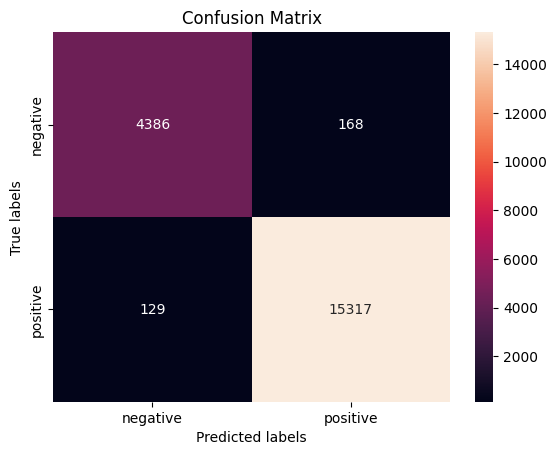

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual_bertje, predicted_bertje)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

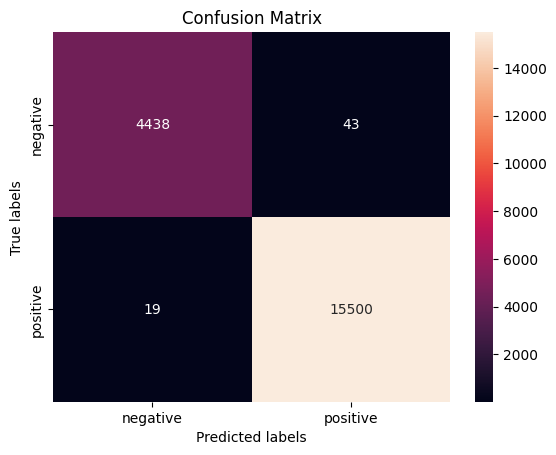

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual_robbert, predicted_robbert)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import logit 

formula = ("false_prediction ~ review_length")

model_bertje = logit(formula=formula, data=bertje).fit()
model_robbert = logit(formula = formula, data=robbert).fit()

Optimization terminated successfully.
         Current function value: 0.074903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020672
         Iterations 10


In [51]:
model_bertje.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       false_prediction   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19998
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 May 2023   Pseudo R-squ.:                 0.03044
Time:                        09:03:17   Log-Likelihood:                -1498.1
converged:                       True   LL-Null:                       -1545.1
Covariance Type:            nonrobust   LLR p-value:                 3.065e-22
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.6806      0.081    -57.902      0.000      -4.839      -4.522
review_length     0.0070      0.001     11.338      0.000       0.006       0.008
=================================================================================
"""

In [52]:
model_robbert.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       false_prediction   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19998
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 May 2023   Pseudo R-squ.:                 0.01570
Time:                        09:03:30   Log-Likelihood:                -413.44
converged:                       True   LL-Null:                       -420.04
Covariance Type:            nonrobust   LLR p-value:                 0.0002816
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.1740      0.175    -35.358      0.000      -6.516      -5.832
review_length     0.0059      0.001      4.229      0.000       0.003       0.009
=================================================================================
"""